In [217]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.stats import kendalltau
import statsmodels.stats.power as smp
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from xgboost import XGBClassifier

# Optional: display settings
pd.set_option('display.max_columns', 100)
%matplotlib inline

In [218]:
!pip install statsmodels
!pip install tensorflow
!pip install xgboost

In [219]:
# ✅ Step 2: Load the dataset
# Replace with your actual path
df = pd.read_csv('../data/raw/disaggregated_DLRM_trace.csv')

In [220]:
import os

# Create output folder if it doesn't exist
output_dir = "./figures"
os.makedirs(output_dir, exist_ok=True)

In [221]:
def save_and_show(filename):
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{filename}", dpi=300)
    plt.show()


In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23871 entries, 0 to 23870
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   instance_sn            23871 non-null  object 
 1   role                   23871 non-null  object 
 2   app_name               23871 non-null  object 
 3   cpu_request            23871 non-null  int64  
 4   cpu_limit              23871 non-null  int64  
 5   gpu_request            23871 non-null  int64  
 6   gpu_limit              23871 non-null  int64  
 7   rdma_request           23871 non-null  int64  
 8   rdma_limit             23871 non-null  int64  
 9   memory_request         23871 non-null  float64
 10  memory_limit           23871 non-null  float64
 11  disk_request           23871 non-null  float64
 12  disk_limit             23871 non-null  float64
 13  max_instance_per_node  23871 non-null  int64  
 14  creation_time          16591 non-null  float64
 15  sc

In [223]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [224]:
df.columns

Index(['instance_sn', 'role', 'app_name', 'cpu_request', 'cpu_limit',
       'gpu_request', 'gpu_limit', 'rdma_request', 'rdma_limit',
       'memory_request', 'memory_limit', 'disk_request', 'disk_limit',
       'max_instance_per_node', 'creation_time', 'scheduled_time',
       'deletion_time'],
      dtype='object')

In [225]:
df.head()

,instance_sn,role,app_name,cpu_request,cpu_limit,gpu_request,gpu_limit,rdma_request,rdma_limit,memory_request,memory_limit,disk_request,disk_limit,max_instance_per_node,creation_time,scheduled_time,deletion_time
0,instance_0,HN,app_0,12,12,1,1,25,25,120.0,120.0,640.0,800.0,8,NaN,NaN,NaN
1,instance_1,HN,app_0,12,12,1,1,25,25,120.0,120.0,680.0,800.0,8,NaN,NaN,NaN
2,instance_2,HN,app_0,12,12,1,1,25,25,120.0,120.0,680.0,800.0,8,NaN,NaN,NaN
3,instance_3,HN,app_0,12,12,1,1,25,25,120.0,120.0,640.0,800.0,8,NaN,NaN,NaN
4,instance_4,HN,app_0,12,12,1,1,25,25,120.0,120.0,640.0,800.0,8,NaN,NaN,NaN


In [226]:
df.describe()

,cpu_request,cpu_limit,gpu_request,gpu_limit,rdma_request,rdma_limit,memory_request,memory_limit,disk_request,disk_limit,max_instance_per_node,creation_time,scheduled_time,deletion_time
count,23871.000000,23871.000000,23871.000000,23871.000000,23871.000000,23871.000000,23871.000000,23871.000000,23871.000000,23871.000000,23871.000000,1.659100e+04,1.659100e+04,1.499300e+04
mean,52.473462,52.473462,0.309413,0.309413,20.806837,20.806837,265.820808,265.820808,308.289598,365.064698,1.138034,1.524417e+06,1.524605e+06,1.515011e+06
std,37.380237,37.380237,0.462261,0.462261,27.237124,27.237124,189.956042,189.956042,185.037698,219.570002,2.711302,6.796387e+05,6.797126e+05,6.920691e+05
min,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,16.000000,16.000000,80.000000,100.000000,-1.000000,4.750000e+02,4.750000e+02,7.500000e+01
25%,8.000000,8.000000,0.000000,0.000000,1.000000,1.000000,40.000000,40.000000,200.000000,200.000000,-1.000000,1.045142e+06,1.045142e+06,1.034238e+06
50%,64.000000,64.000000,0.000000,0.000000,25.000000,25.000000,320.000000,320.000000,255.000000,300.000000,-1.000000,1.694853e+06,1.694853e+06,1.695368e+06
75%,64.000000,64.000000,1.000000,1.000000,25.000000,25.000000,320.000000,320.000000,384.000000,480.000000,2.000000,2.037270e+06,2.039824e+06,2.040553e+06
max,192.000000,192.000000,1.000000,1.000000,100.000000,100.000000,1000.000000,1000.000000,996.000000,1171.879883,16.000000,2.676636e+06,2.676679e+06,2.677541e+06


In [227]:
df["app_name"].value_counts()

app_name
app_0      2551
app_87     1817
app_19      940
app_2       775
app_20      691
           ... 
app_92        6
app_40        5
app_105       5
app_121       5
app_155       3
Name: count, Length: 156, dtype: int64

In [228]:
smp.tt_ind_solve_power(effect_size=0.5, alpha=0.05, power=0.8)

63.7656117754095

In [229]:
df['rdma_gap'] = df['rdma_limit'] - df['rdma_request']
df['rdma_ratio'] = df['rdma_request'] / df['rdma_limit'].replace(0, pd.NA)

# Descriptive stats
print(df[['rdma_gap', 'rdma_ratio']].describe())

       rdma_gap  rdma_ratio
count   23871.0     23871.0
mean        0.0         1.0
std         0.0         0.0
min         0.0         1.0
25%         0.0         1.0
50%         0.0         1.0
75%         0.0         1.0
max         0.0         1.0


In [230]:
df['disk_gap'] = df['disk_limit'] - df['disk_request']
df['disk_ratio'] = df['disk_request'] / df['disk_limit'].replace(0, pd.NA)

# Summary statistics
print(df[['disk_gap', 'disk_ratio']].describe())

           disk_gap    disk_ratio
count  23871.000000  23871.000000
mean      56.775099      0.847341
std       35.621044      0.031113
min        0.000000      0.800000
25%       40.000000      0.850000
50%       45.000000      0.850000
75%       75.000000      0.850000
max      233.879883      1.000000


In [231]:
# Drop rows with missing timestamps
print("Missing creation_time:", df['creation_time'].isnull().sum())
print("Missing deletion_time:", df['deletion_time'].isnull().sum())
print("Missing scheduled_time:", df['scheduled_time'].isnull().sum())
df = df.dropna(subset=['creation_time', 'deletion_time','scheduled_time'])
print("Remaining rows after dropping NaN:", len(df))

print("creation_time range:", df['creation_time'].min(), "to", df['creation_time'].max())
print("deletion_time range:", df['deletion_time'].min(), "to", df['deletion_time'].max())
print("scheduled_time range:", df['scheduled_time'].min(), "to", df['scheduled_time'].max())


Missing creation_time: 7280
Missing deletion_time: 8878
Missing scheduled_time: 7280
Remaining rows after dropping NaN: 12390
creation_time range: 475.00000000000006 to 2676503.0
deletion_time range: 2843.0 to 2677541.0
scheduled_time range: 475.00000000000006 to 2676503.0


In [232]:
# Recalculate durations safely
df.loc[:, 'wait_time'] = df['scheduled_time'] - df['creation_time']
df.loc[:, 'run_time'] = df['deletion_time'] - df['scheduled_time']
df.loc[:, 'total_lifetime'] = df['deletion_time'] - df['creation_time']

df.loc[:, 'wait_time_hours'] = df['wait_time'] / 3600
df.loc[:, 'run_time_hours'] = df['run_time'] / 3600

In [233]:
# Check for any negative durations
print("Negative wait times:", (df['wait_time'] < 0).sum())
print("Negative run times:", (df['run_time'] < 0).sum())
print("Negative total lifetime:", (df['total_lifetime'] < 0).sum())

# Get basic stats
df[['wait_time', 'run_time', 'total_lifetime']].describe()

Negative wait times: 0
Negative run times: 0
Negative total lifetime: 0


,wait_time,run_time,total_lifetime
count,12390.000000,1.239000e+04,1.239000e+04
mean,119.895319,1.024910e+05,1.026109e+05
std,2697.630141,2.600620e+05,2.600560e+05
min,0.000000,0.000000e+00,0.000000e+00
25%,0.000000,1.151000e+03,1.152000e+03
50%,0.000000,8.278500e+03,8.409000e+03
75%,1.000000,6.775425e+04,6.785100e+04
max,235230.000000,2.462429e+06,2.462429e+06


In [234]:
# Avoid divide-by-zero
df['cpu_mem_ratio'] = df['cpu_request'] / df['memory_request'].replace(0, np.nan)
df['gpu_intensity'] = df['gpu_request'] / df['cpu_request'].replace(0, np.nan)

# Alias durations
df['job_duration'] = df['run_time']
df['waiting_time'] = df['wait_time']

# Flag long jobs (you can adjust the threshold)
df['is_long_job'] = df['run_time_hours'] > 24

# Duration buckets
def bucket_duration(hours):
    if hours <= 1:
        return 'short'
    elif hours <= 12:
        return 'medium'
    elif hours <= 72:
        return 'long'
    else:
        return 'very long'

df['duration_bucket'] = df['run_time_hours'].apply(bucket_duration)


In [235]:
df[['instance_sn', 'cpu_request', 'memory_request', 'cpu_mem_ratio', 
          'gpu_request', 'gpu_intensity', 'run_time_hours', 'duration_bucket']].head()

,instance_sn,cpu_request,memory_request,cpu_mem_ratio,gpu_request,gpu_intensity,run_time_hours,duration_bucket
7281,instance_7281,64,320.0,0.2000,0,0.0,25.290833,long
7284,instance_7284,96,480.0,0.2000,0,0.0,0.657778,short
7286,instance_7286,192,937.5,0.2048,0,0.0,0.871667,short
7288,instance_7288,64,320.0,0.2000,0,0.0,1.209167,medium
7289,instance_7289,64,320.0,0.2000,0,0.0,37.995000,long


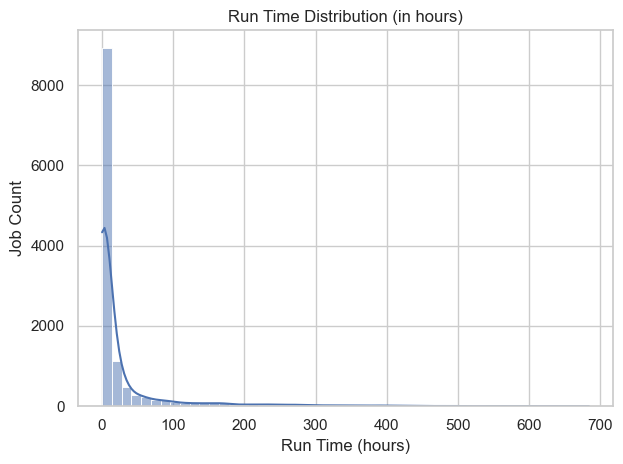

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of run time
sns.histplot(df['run_time_hours'], bins=50, kde=True)
plt.title("Run Time Distribution (in hours)")
plt.xlabel("Run Time (hours)")
plt.ylabel("Job Count")
plt.savefig("job_run_time_distribution.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

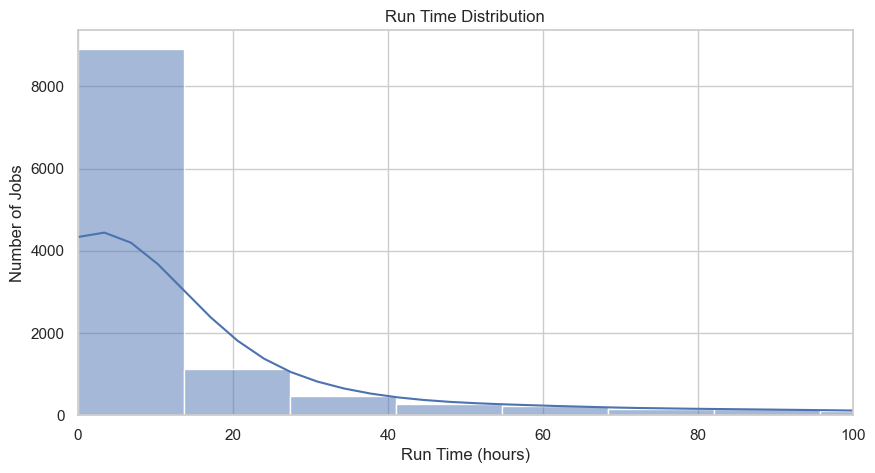

In [237]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(df['run_time_hours'], bins=50, kde=True)
plt.title("Run Time Distribution")
plt.xlabel("Run Time (hours)")
plt.ylabel("Number of Jobs")
plt.xlim(0, 100)  # Focus on first 100 hours to reduce skew
plt.show()


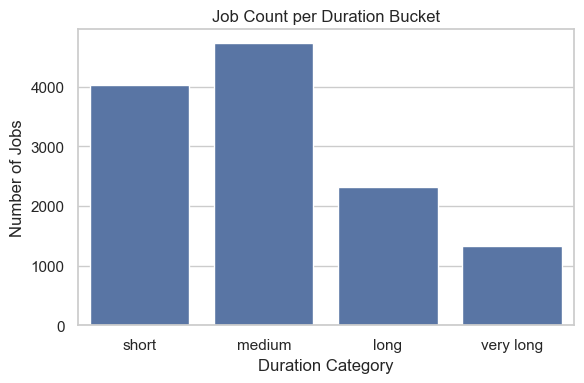

In [238]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='duration_bucket', order=['short', 'medium', 'long', 'very long'])
plt.title("Job Count per Duration Bucket")
plt.xlabel("Duration Category")
plt.ylabel("Number of Jobs")
save_and_show("Job_Count_per_Duration_Bucket.png")

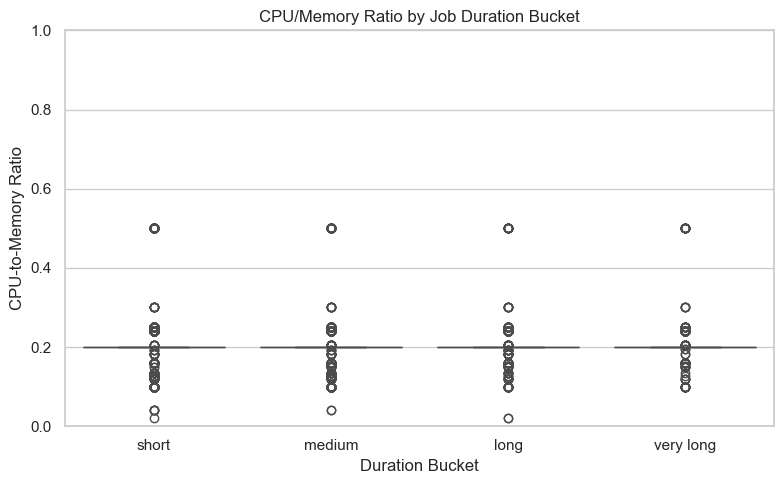

In [239]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='duration_bucket', y='cpu_mem_ratio', order=['short', 'medium', 'long', 'very long'])
plt.title("CPU/Memory Ratio by Job Duration Bucket")
plt.xlabel("Duration Bucket")
plt.ylabel("CPU-to-Memory Ratio")
plt.ylim(0, 1)
save_and_show("CPU_Memory_Ratio_by_Job_Duration_Bucket")

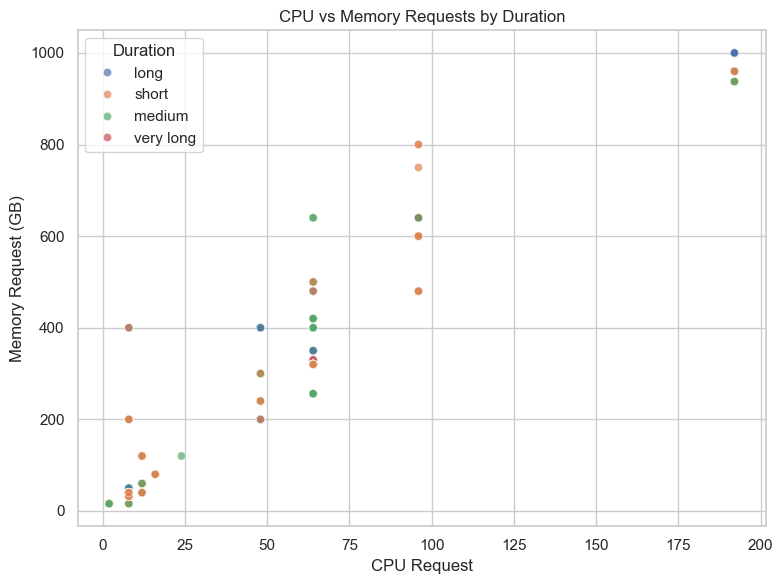

In [240]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='cpu_request', y='memory_request', hue='duration_bucket', alpha=0.7)
plt.title("CPU vs Memory Requests by Duration")
plt.xlabel("CPU Request")
plt.ylabel("Memory Request (GB)")
plt.legend(title='Duration')
save_and_show("CPU_vs_Memory_Requests_by_Duration")

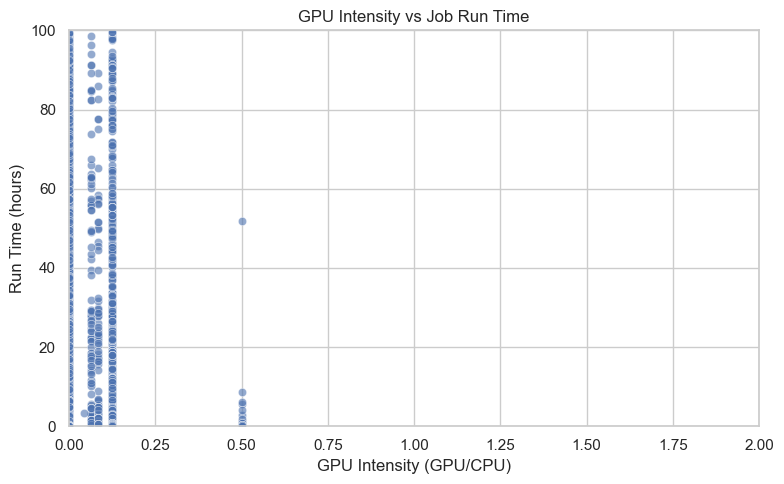

In [241]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df[df['gpu_intensity'].notna()], x='gpu_intensity', y='run_time_hours', alpha=0.6)
plt.title("GPU Intensity vs Job Run Time")
plt.xlabel("GPU Intensity (GPU/CPU)")
plt.ylabel("Run Time (hours)")
plt.xlim(0, 2)
plt.ylim(0, 100)
save_and_show("GPU_Intensity_vs_Job_Run_Time.png")

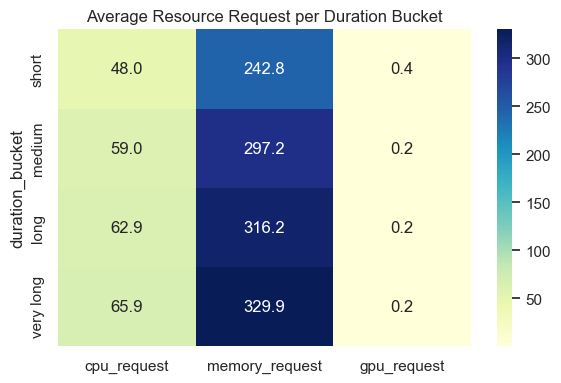

In [242]:
# Group and compute mean values
grouped = df.groupby('duration_bucket')[['cpu_request', 'memory_request', 'gpu_request']].mean()

# Reorder duration buckets
grouped = grouped.loc[['short', 'medium', 'long', 'very long']]

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(grouped, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Average Resource Request per Duration Bucket")
save_and_show("Average_Resource_Request_per_Duration_Bucket.png")

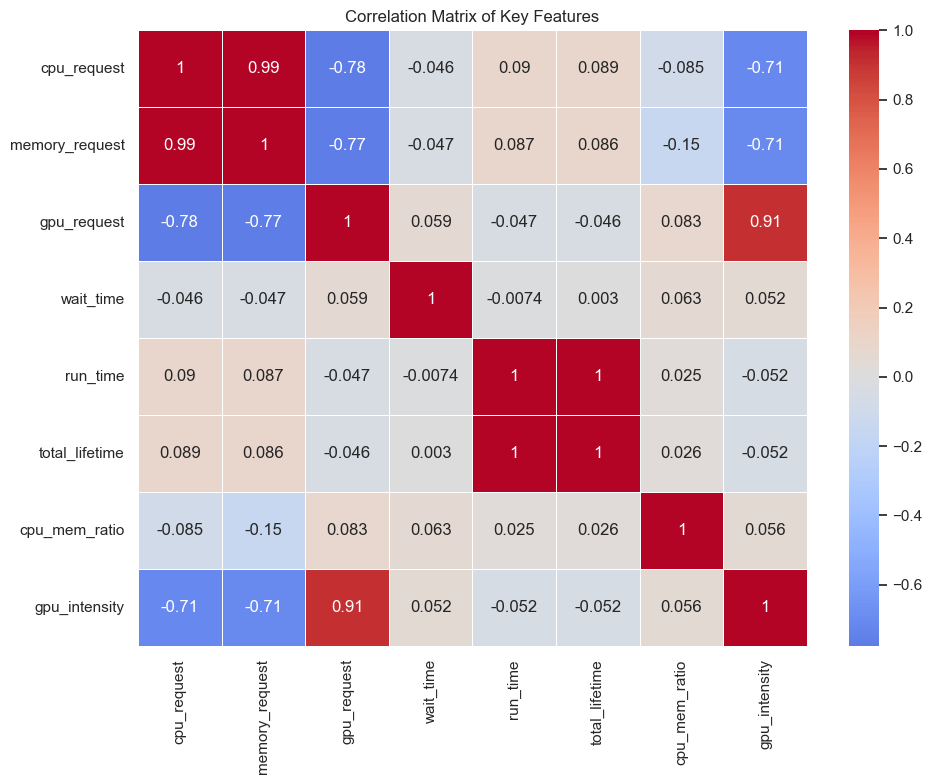

In [243]:
# Select numeric features
numeric_cols = ['cpu_request', 'memory_request', 'gpu_request', 
                'wait_time', 'run_time', 'total_lifetime', 
                'cpu_mem_ratio', 'gpu_intensity']

# Compute correlation
corr = df[numeric_cols].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix of Key Features")
save_and_show("Correlation_Matrix_of_Key_Features.png")

C:\Users\HSampatirao\AppData\Local\Temp\ipykernel_18576\2256881258.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




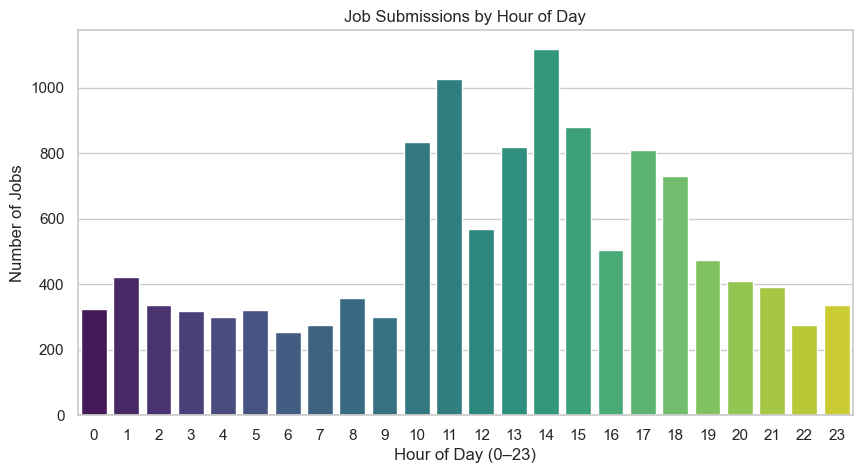

In [244]:
# Define base time for relative timestamps
base_time = pd.to_datetime('2025-01-01')

# Convert creation_time (in milliseconds) to datetime
df['creation_dt'] = base_time + pd.to_timedelta(df['creation_time'].astype(float) , unit='s', errors='coerce')

# Extract hour of day
df['creation_hour'] = df['creation_dt'].dt.hour

# Check for invalid conversions
if df['creation_hour'].isnull().sum() > 0:
    print(f"Warning: {df['creation_hour'].isnull().sum()} rows with invalid creation_time values")

# Plot distribution of job submissions by hour
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='creation_hour', palette="viridis")
plt.title("Job Submissions by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Jobs")
plt.savefig("Job_Submissions_by_Hour_of_Day.png")
plt.show()

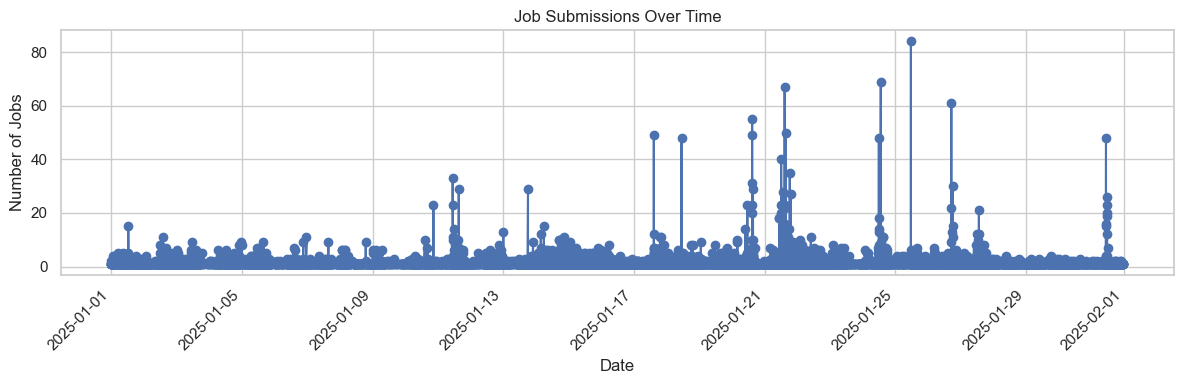

In [245]:
# Define base time for relative timestamps
base_time = pd.to_datetime('2025-01-01')

# Convert creation_time (in milliseconds) to datetime
df['creation_date'] = base_time + pd.to_timedelta(df['creation_time'].astype(float) , unit='s', errors='coerce')

# Jobs submitted per day
daily_jobs = df.groupby('creation_date').size()

plt.figure(figsize=(12, 4))
daily_jobs.plot(marker='o')
plt.title("Job Submissions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Jobs")
plt.xticks(rotation=45)
plt.grid(True)
save_and_show("Job_Submissions_Over_Time.png")

In [246]:
# Create derived features
df['cpu_memory_ratio'] = df['cpu_request'] / df['memory_request']
df['gpu_cpu_ratio'] = df['gpu_request'] / df['cpu_request']
df['memory_disk_ratio'] = df['memory_request'] / df['disk_request']

In [247]:
# Encode categorical variables
df['role_encoded'] = pd.Categorical(df['role']).codes
df['app_name_encoded'] = pd.Categorical(df['app_name']).codes

# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 instance_sn              0
role                     0
app_name                 0
cpu_request              0
cpu_limit                0
gpu_request              0
gpu_limit                0
rdma_request             0
rdma_limit               0
memory_request           0
memory_limit             0
disk_request             0
disk_limit               0
max_instance_per_node    0
creation_time            0
scheduled_time           0
deletion_time            0
rdma_gap                 0
rdma_ratio               0
disk_gap                 0
disk_ratio               0
wait_time                0
run_time                 0
total_lifetime           0
wait_time_hours          0
run_time_hours           0
cpu_mem_ratio            0
gpu_intensity            0
job_duration             0
waiting_time             0
is_long_job              0
duration_bucket          0
creation_dt              0
creation_hour            0
creation_date            0
cpu_memory_ratio         0
gpu_cpu_rat

In [248]:
df['runtime'] = (df['deletion_time'] - df['creation_time'])

Cluster Summary:
          cpu_request  gpu_request  memory_request  disk_request  rdma_request  \
cluster                                                                         
0          66.127854     0.082192      332.448630    373.607306     16.139269   
1          62.196223     0.000691      312.215569    262.174344     36.601105   
2          51.624691     0.111111      264.670617    608.918025     10.702222   
3           8.304672     1.000000       40.299255    125.247123     28.174340   
4         105.073356     0.000000      529.950589    282.188902      6.264158   

              runtime  cpu_memory_ratio  gpu_cpu_ratio  memory_disk_ratio  
cluster                                                                    
0        1.185793e+06          0.202134       0.009465           1.046401  
1        4.822052e+04          0.199364       0.000086           1.197467  
2        5.963309e+04          0.192985       0.009259           0.460133  
3        6.859948e+04          0.2

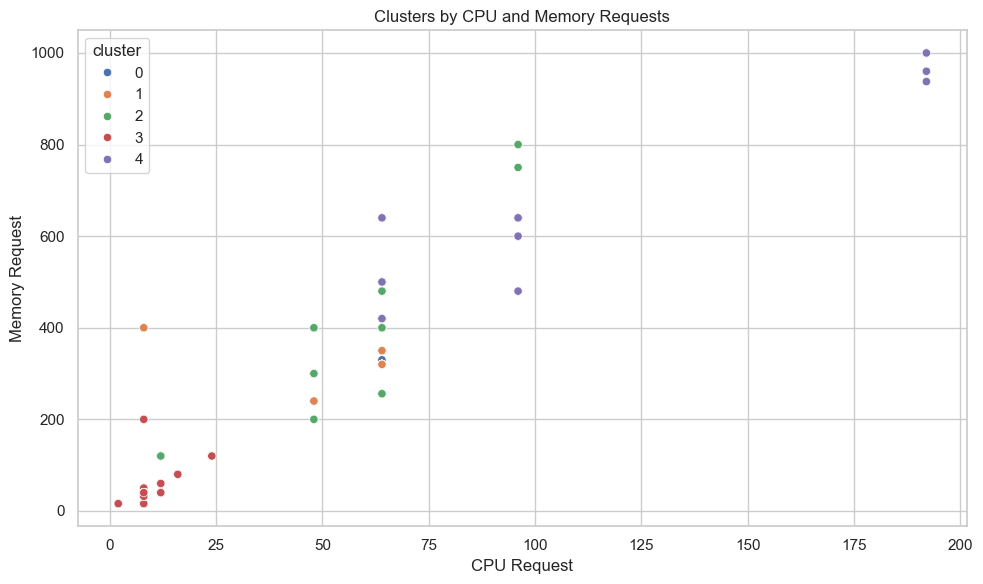

In [249]:
# ✅ Step 5: Feature Engineering and Clustering
# Select features for clustering
features = ['cpu_request', 'gpu_request', 'memory_request', 'disk_request', 'rdma_request', 'runtime', 'cpu_memory_ratio', 'gpu_cpu_ratio', 'memory_disk_ratio']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = df.groupby('cluster')[features].mean()
print("Cluster Summary:\n", cluster_summary)

# Visualize clusters (example: CPU vs. Memory)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cpu_request', y='memory_request', hue='cluster', palette='deep', data=df)
plt.title('Clusters by CPU and Memory Requests')
plt.xlabel('CPU Request')
plt.ylabel('Memory Request')
save_and_show('cluster_scatter.png')

In [250]:
# Supervised Classification
# Assume we have a labeled subset based on clusters
label_mapping = {
    0: 'Preprocessing',
    1: 'Training',
    2: 'Tuning',
    3: 'Inference',
    4: 'Deployment'
}
df['workload_type'] = df['cluster'].map(label_mapping)

# Encode the string labels into numerical values
label_encoder = LabelEncoder()
df['workload_type_encoded'] = label_encoder.fit_transform(df['workload_type'])

# Print the mapping of labels to integers for reference
label_mapping_encoded = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:", label_mapping_encoded)

# Select features and encoded target
features = ['cpu_request', 'gpu_request', 'memory_request', 'disk_request', 'rdma_request', 'runtime', 'cpu_memory_ratio', 'gpu_cpu_ratio', 'memory_disk_ratio']
X = df[features]
y = df['workload_type_encoded']  # Use the encoded labels

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)  # Convert predictions back to string labels
y_test_labels = label_encoder.inverse_transform(y_test)  # Convert test labels back to string labels
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

# Save predictions
df['predicted_workload_type'] = label_encoder.inverse_transform(model.predict(df[features]))
df[['instance_sn', 'predicted_workload_type']].to_csv('./figures/predicted_workloads.csv', index=False)
print("Predictions saved to './figures/predicted_workloads.csv'")

Label Encoding Mapping: {'Deployment': 0, 'Inference': 1, 'Preprocessing': 2, 'Training': 3, 'Tuning': 4}
Classification Report:
                precision    recall  f1-score   support

   Deployment       0.99      1.00      1.00       516
    Inference       1.00      1.00      1.00       588
Preprocessing       1.00      1.00      1.00        90
     Training       1.00      1.00      1.00       871
       Tuning       1.00      1.00      1.00       413

     accuracy                           1.00      2478
    macro avg       1.00      1.00      1.00      2478
 weighted avg       1.00      1.00      1.00      2478

Predictions saved to './figures/predicted_workloads.csv'


Number of clusters (excluding noise): 39
Number of noise points: 406
Cluster Summary:
          cpu_request  gpu_request  memory_request  disk_request  rdma_request  \
cluster                                                                         
-1         54.280788     0.300493      294.549261    377.130542     17.150246   
 0         64.000000     0.000000      320.641164    253.165409      1.000000   
 1         96.000000     0.000000      480.000000    253.490520      1.000000   
 2        192.000000     0.000000      937.500000    510.000000     51.000000   
 3         64.000000     0.000000      320.000000    381.828897      1.000000   
 4        192.000000     0.000000      960.000000    340.000000     51.000000   
 5         48.000000     0.000000      200.000000    680.000000     25.000000   
 6         12.000000     1.000000      120.000000    680.000000     23.568182   
 7          8.000000     1.000000       40.000000    122.560020     25.000000   
 8         64.000000  

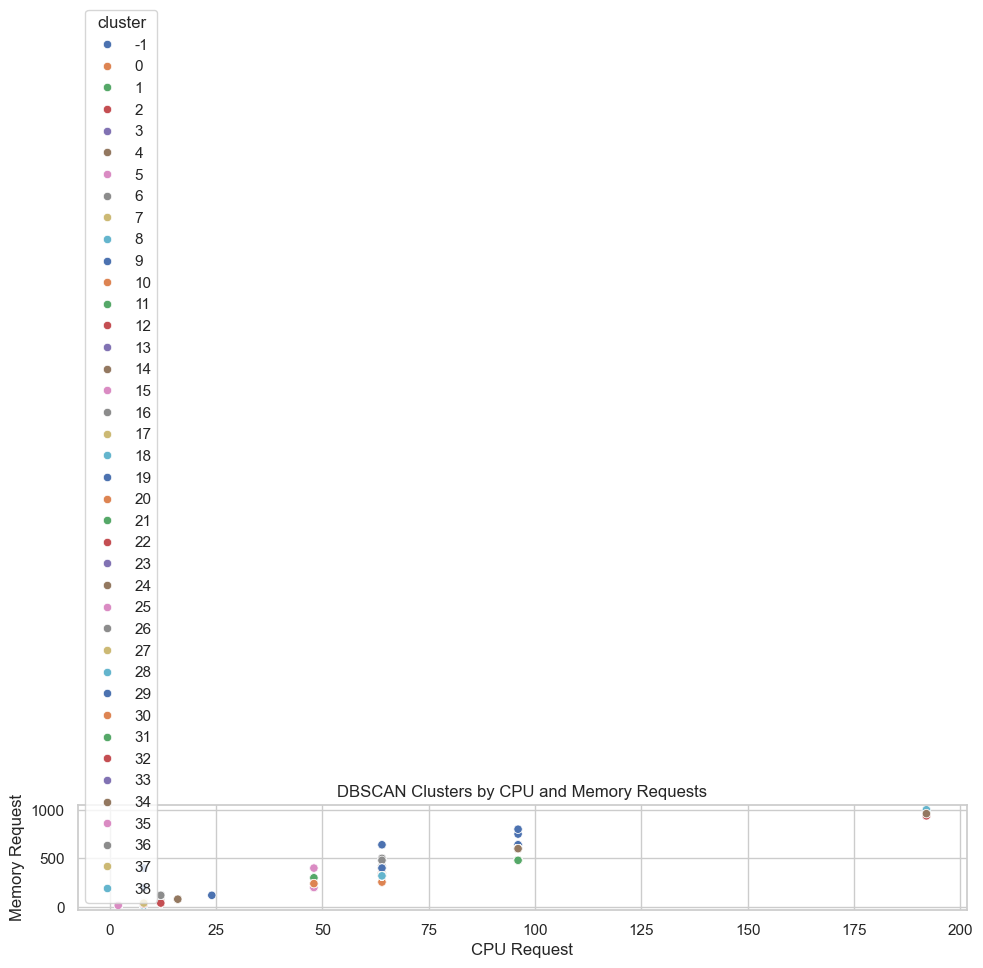

DBSCAN clustering results saved to './figures/dbscan_workload_classification.csv'


In [251]:
# Step 5: Feature Engineering and DBSCAN Clustering
# Select features for clustering
features = ['cpu_request', 'gpu_request', 'memory_request', 'disk_request', 'rdma_request', 'runtime', 'cpu_memory_ratio', 'gpu_cpu_ratio', 'memory_disk_ratio']

# Standardize features (DBSCAN is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Apply DBSCAN
# eps: maximum distance between two points to be considered in the same cluster
# min_samples: minimum number of points to form a dense region (cluster)
dbscan = DBSCAN(eps=0.5, min_samples=10)
df['cluster'] = dbscan.fit_predict(X_scaled)

# Analyze clusters
print("Number of clusters (excluding noise):", len(set(df['cluster']) - {-1}))
print("Number of noise points:", (df['cluster'] == -1).sum())
cluster_summary = df.groupby('cluster')[features].mean()
print("Cluster Summary:\n", cluster_summary)

# Visualize clusters (CPU vs. Memory)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cpu_request', y='memory_request', hue='cluster', palette='deep', data=df)
plt.title('DBSCAN Clusters by CPU and Memory Requests')
plt.xlabel('CPU Request')
plt.ylabel('Memory Request')
save_and_show('dbscan_cluster_scatter.png')

# Map clusters to workload types (manual mapping based on cluster characteristics)
# Example mapping (adjust based on cluster_summary)
label_mapping = {
    -1: 'Noise',  # Outliers
    0: 'Preprocessing',
    1: 'Training',
    2: 'Tuning',
    3: 'Inference',
    4: 'Deployment'
}
df['workload_type'] = df['cluster'].map(label_mapping).fillna('Unknown')

# Save clustering results
df[['instance_sn', 'cluster', 'workload_type']].to_csv('./figures/dbscan_workload_classification.csv', index=False)
print("DBSCAN clustering results saved to './figures/dbscan_workload_classification.csv'")

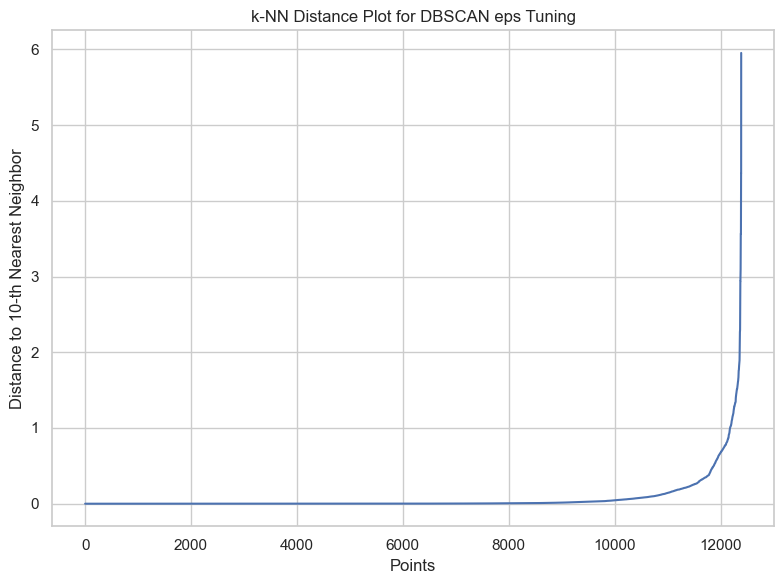

In [252]:
# Compute distances to the min_samples-th nearest neighbor
neighbors = NearestNeighbors(n_neighbors=10)  # Should match min_samples
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])  # Sort distances to the min_samples-th neighbor

# Plot distances to find the "elbow"
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('k-NN Distance Plot for DBSCAN eps Tuning')
plt.xlabel('Points')
plt.ylabel(f'Distance to {10}-th Nearest Neighbor')
save_and_show('knn_distance_plot.png')

In [253]:
score = silhouette_score(X_scaled, df['cluster'])
print("Silhouette Score:", score)

Silhouette Score: 0.5796260737755061


In [254]:
cluster_summary = df.groupby('cluster')[features].mean()
print("Cluster Summary:\n", cluster_summary)

Cluster Summary:
          cpu_request  gpu_request  memory_request  disk_request  rdma_request  \
cluster                                                                         
-1         54.280788     0.300493      294.549261    377.130542     17.150246   
 0         64.000000     0.000000      320.641164    253.165409      1.000000   
 1         96.000000     0.000000      480.000000    253.490520      1.000000   
 2        192.000000     0.000000      937.500000    510.000000     51.000000   
 3         64.000000     0.000000      320.000000    381.828897      1.000000   
 4        192.000000     0.000000      960.000000    340.000000     51.000000   
 5         48.000000     0.000000      200.000000    680.000000     25.000000   
 6         12.000000     1.000000      120.000000    680.000000     23.568182   
 7          8.000000     1.000000       40.000000    122.560020     25.000000   
 8         64.000000     0.000000      320.000000    255.000000    100.000000   
 9        

In [255]:
app_cluster_dist = df.groupby(['cluster', 'app_name']).size().unstack(fill_value=0)
print("App Name Distribution by Cluster:\n", app_cluster_dist)

App Name Distribution by Cluster:
 app_name  app_0  app_1  app_10  app_100  app_101  app_102  app_103  app_104  \
cluster                                                                       
-1           35      0       0        5        5        0        1        5   
 0            0      0       0        7        0        0        0        0   
 1            0      0       2        0        0        1        0        0   
 2            0      0       0        0        0        0        0        0   
 3            0      0       0        0        0        0        7        0   
 4            0      0       0        0        0        0        0        0   
 5          392      0       0        0        0        0        0        0   
 6          199      0       0        0        0        0        0        0   
 7            0      0       0        0        0        0        2        0   
 8            0      0       0        0        0        0        0        0   
 9          198  

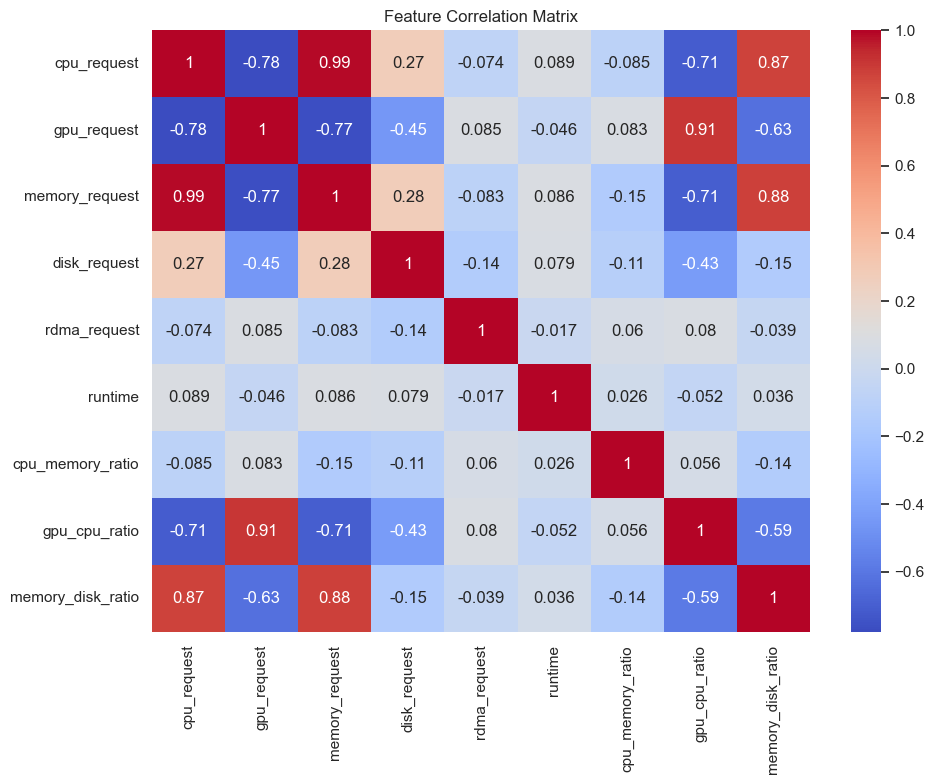

In [256]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
save_and_show('feature_correlation.png')

In [257]:
# Encode workload_type
label_encoder = LabelEncoder()
df['workload_type_encoded'] = label_encoder.fit_transform(df['workload_type'])

# Split data
X = df[features]
y = df['workload_type_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))

# Save predictions
df['predicted_workload_type'] = label_encoder.inverse_transform(model.predict(X))
df[['instance_sn', 'predicted_workload_type']].to_csv('./figures/predicted_workloads.csv', index=False)

Classification Report:
                precision    recall  f1-score   support

   Deployment       1.00      1.00      1.00        44
    Inference       1.00      1.00      1.00        58
        Noise       1.00      0.93      0.96        84
Preprocessing       0.99      1.00      1.00       377
     Training       1.00      1.00      1.00       391
       Tuning       1.00      1.00      1.00        12
      Unknown       1.00      1.00      1.00      1512

     accuracy                           1.00      2478
    macro avg       1.00      0.99      0.99      2478
 weighted avg       1.00      1.00      1.00      2478



In [258]:

# Group by app and compute average resource usage
app_stats = df.groupby('app_name').agg({
    'cpu_request': 'mean',
    'gpu_request': 'mean',
    'rdma_request': 'mean',
    'memory_request': 'mean',
    'disk_request': 'mean'
}).reset_index()

# Normalize features
features = ['cpu_request', 'gpu_request', 'rdma_request', 'memory_request', 'disk_request']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(app_stats[features])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
app_stats['cluster'] = kmeans.fit_predict(X_scaled)

# Merge cluster info back into main dataframe
df = df.merge(app_stats[['app_name', 'cluster']], on='app_name', how='left')

# View cluster distribution
print(df['cluster'].value_counts())


C:\Users\HSampatirao\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



KeyError: 'cluster'

In [ ]:
# Use PCA to visualize 2D projection of clusters
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
app_stats['pca_1'] = X_pca[:, 0]
app_stats['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=app_stats, x='pca_1', y='pca_2', hue='cluster', palette='Set2')
plt.title('K-Means Clustering of Workloads')
save_and_show('K-Means_Clustering_of_Workloads.png')
plt.show()


In [ ]:
app_stats.groupby('cluster')[features].mean()

In [ ]:
cluster_map = {
    0: 'Deep Learning',
    1: 'Agentic',
    2: 'Generative',
    3: 'ML',
    4: 'Non-AI'
}

df['workload_category'] = df['cluster'].map(cluster_map)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='workload_category', order=df['workload_category'].value_counts().index, palette='Set2')
plt.title("Workload Category Distribution")
plt.ylabel("Number of Instances")
plt.xlabel("Category")
plt.xticks(rotation=20)
plt.tight_layout()
save_and_show('Workload_Category_Distribution.png')
plt.show()

In [ ]:
util_summary = df.groupby('workload_category')[['cpu_request', 'gpu_request', 'rdma_request', 'memory_request', 'disk_request']].mean().round(1)
print(util_summary)

In [ ]:
util_summary.T.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title("Average Resource Usage by Workload Category")
plt.ylabel("Average Usage")
plt.xticks(rotation=0)
plt.tight_layout()
save_and_show('Average_Resource_Usage_by_Workload_Category.png')
plt.show()

In [ ]:
# Sample only necessary columns
plot_data = df[['cpu_request', 'gpu_request', 'rdma_request', 'memory_request', 'disk_request', 'workload_category']]

# Create pairplot
sns.set(style="whitegrid")
g = sns.pairplot(
    plot_data,
    hue="workload_category",
    palette="Set2",
    corner=True,
    diag_kind="kde",
    plot_kws={'alpha': 0.6}
)
g.fig.suptitle("Pairwise Comparison of Resource Usage by Category", y=1.02)
plt.tight_layout()
save_and_show('Pairwise_Comparison_of_Resource_Usage_by_Category.png')
plt.show()

In [ ]:

# Use same sample subset
plot_data = df[['cpu_request', 'gpu_request', 'rdma_request', 'memory_request', 'disk_request', 'workload_category']]

# Create interactive scatter matrix
fig = px.scatter_matrix(
    plot_data,
    dimensions=['cpu_request', 'gpu_request', 'rdma_request', 'memory_request', 'disk_request'],
    color='workload_category',
    title='Interactive Dashboard of Workload Resource Usage',
    height=800,
    width=900
)

fig.update_traces(diagonal_visible=False)
save_and_show('Interactive_Dashboard_of_Workload_Resource_Usage.png')
fig.show()

In [ ]:
job_type = ['batch', 'ai', 'online']

In [ ]:
features = [
    'cpu_request', 'memory_request', 'gpu_request',
    'cpu_mem_ratio', 'gpu_intensity',
    'run_time_hours', 'wait_time_hours'
]

X = df[features].dropna()

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df.loc[X.index, 'cluster'] = clusters

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x='cluster', data=df)
plt.title("Job Count per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Jobs")
save_and_show('Job_Count_per_Cluster.png')
plt.show()

In [ ]:
df.groupby('cluster')[features].mean()

In [ ]:
cluster_label_map = {
    0.0: 'ai',
    1.0: 'batch',
    2.0: 'ai-long'
}

df['job_type'] = df['cluster'].map(cluster_label_map)

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='job_type', order=['batch', 'ai', 'ai-long'])
plt.title("Job Count by Labeled Workload Type")
plt.xlabel("Workload Type")
plt.ylabel("Number of Jobs")
save_and_show('Job_Count_by_Labeled_Workload_Type.png')
plt.show()

In [ ]:
group_summary = df.groupby('job_type')[
    ['cpu_request', 'memory_request', 'gpu_request', 'run_time_hours', 'wait_time_hours']
].agg(['mean', 'median', 'std', 'min', 'max']).round(2)

group_summary.columns = ['_'.join(col) for col in group_summary.columns]
group_summary.reset_index(inplace=True)

In [ ]:
group_summary.to_csv("job_type_summary_table.csv", index=False)

In [ ]:
summary_melted = df.groupby('job_type')[
    ['cpu_request', 'memory_request', 'gpu_request', 'run_time_hours', 'wait_time_hours']
].mean().reset_index().melt(id_vars='job_type', var_name='Resource', value_name='MeanValue')

plt.figure(figsize=(12, 6))
sns.barplot(data=summary_melted, x='Resource', y='MeanValue', hue='job_type')
plt.title("Mean Resource Usage and Duration by Job Type")
plt.ylabel("Mean Value")
plt.xticks(rotation=30)
plt.tight_layout()
#plt.savefig("job_type_summary_plot.png", dpi=300)
save_and_show('job_type_summary_plot.png')
plt.show()

In [ ]:
features = [
    'cpu_request', 'memory_request', 'gpu_request',
    'cpu_mem_ratio', 'gpu_intensity',
    'run_time_hours', 'wait_time_hours'
]

X = df[features]
y = df['job_type']


In [ ]:


le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [ ]:

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
save_and_show('Confusion_Matrix.png')
plt.show()

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
sns.barplot(x=importances[indices], y=np.array(features)[indices])
plt.title("Feature Importance in Job Type Classification")
plt.tight_layout()
save_and_show('Feature_Importance_in_Job_Type_Classification.png')
plt.show()

In [ ]:
#  Encode Labels (if categorical)
if y.dtype == 'O':
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
else:
    y_encoded = y

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ANN Model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=1)

# ANN Predictions
ann_preds = ann_model.predict(X_test_scaled).argmax(axis=1)
print("\n ANN Accuracy:", accuracy_score(y_test, ann_preds))
print(confusion_matrix(y_test, ann_preds))
print(classification_report(y_test, ann_preds, target_names=le.classes_))

# XGBoost Model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluation
print("\n XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(confusion_matrix(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds, target_names=le.classes_))

# Feature Importance for XGBoost
xgb.plot_importance(xgb_model, max_num_features=10, height=0.5)
plt.title("XGBoost Feature Importance")
save_and_show('XGBoost_Feature_Importance.png')
plt.show()

In [ ]:
# Replace with your actual label encoder if used
labels = ['ai', 'ai-long', 'batch']  # Update this if your label encoder order is different

# Calculate confusion matrices
cm_ann = confusion_matrix(y_test, ann_preds)
cm_xgb = confusion_matrix(y_test, xgb_preds)

# Plot function
def plot_confusion_matrix(cm, title, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'{title} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    save_and_show('{title}_Confusion_Matrix.png')
    plt.show()

# Plot ANN confusion matrix
plot_confusion_matrix(cm_ann, 'ANN', labels)

# Plot XGBoost confusion matrix
plot_confusion_matrix(cm_xgb, 'XGBoost', labels)
